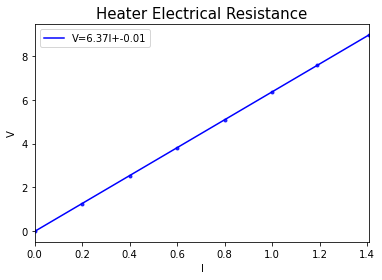

Heater Resistance: 6.37 +/- 0.01 Ohms 

----------------------------------------------------------



In [1]:
# read the csv files 
import pandas as pd
import sys, os, re, glob
import numpy as np

from scipy.interpolate import splev, splrep

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from matplotlib import pylab

#import seaborn as sns

import seaborn as sns


#########-- Heater resistance ------#######
resistance = pd.read_csv("IV_heater.csv",sep=",", index_col=None) # read info from csv file

V=resistance.V # Voltages from power supply (digital multmeter)
I=resistance.I # Currents from power supply (digital multmeter)

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(I,V)

# use line_kws to set line label for legend
ax = sns.regplot(x="I", y="V", data=resistance, color='b',marker=".", 
 line_kws={"linewidth": 1.5,'label':"V={0:.2f}I+{1:.2f}".format(slope,intercept)})

pylab.title('Heater Electrical Resistance',fontsize=15)
# plot legend
ax.legend()
plt.show()
 #slope and std_err are the Mock module resistance and its error
print("Heater Resistance: %.2f +/- %.2f Ohms \n" %(slope,std_err) )
print("----------------------------------------------------------\n") 


    

In [49]:
########----Power function ----------########

alpha=4.28*10**-17
flu=[1.0*10**16, 2.1*10**16, 3.0*10**16, 4.0*10**16]
h=4.4                  #width of the sensor
l=1.8                  #lenght of the sensor
dd=130*10**-4          #depletion depth
Vb=600                 #bias voltage
Tr=293                 #reference Temperature
Ta=7000                #Activation Temperature
Qbl=5.92               #Q baseline from ROC's
T0=253

Tmax= 310

# Q reference calculations: there are one Qr for each fluence  
# so Qr is a list of "# of fluence values" elements

Qr=[]
cntf=0 # counter for fluence

for f in flu:
    Qr.append(alpha*f*h*l*dd*Vb)
    print('Qref(T=20C, Fluence = %1.1f e16)'%(cntf+1.0),'= %0.2f W'%(Qr[cntf]))
    cntf= cntf + 1

# Calculations of Q as a function of Tsensor    

Ts=[]         # Tsensor
Ts_e=[]       # Tsensor translated by 53
Ts_ec=[]      # Tsensor translated (extended) by and converted to Celsius scale
Q1=[]         # heat generated by sensor under fluence flu[0] 
Q2=[]
Q3=[]
Q4=[]
Q1e=[]
Q2e=[]
Q3e=[]
Q4e=[]
Q=[Q1,Q2,Q3,Q4]  # list of datasets for fluences in flu and 240<Ts<303 
Qe=[Q1e,Q2e,Q3e,Q4e]  # list of datasets for fluences in flu and 240<Ts<303 


for T in np.arange(240, 303, 1):
    Ts.append(T)
    Ts_e.append(T + 53)
    Ts_ec.append(T + 53 - 273)
 
for t1,t2 in zip(Ts, Ts_e):
    cntf=0
    for q in Qr:
        Q[cntf].append(Qr[cntf]*((t1/Tr)**2)*np.exp(-Ta*(1/t1 - 1/Tr)))
        Qe[cntf].append(Qr[cntf]*((t2/Tr)**2)*np.exp(-Ta*(1/t2 - 1/Tr)))
        cntf=cntf +1


Qref(T=20C, Fluence = 1.0 e16) = 26.44 W
Qref(T=20C, Fluence = 2.0 e16) = 55.52 W
Qref(T=20C, Fluence = 3.0 e16) = 79.32 W
Qref(T=20C, Fluence = 4.0 e16) = 105.76 W


In [52]:
    
Q_T = pd.DataFrame()
Q_T['Ts']=Ts
Q_T['Ts_e']=Ts_e
Q_T['Ts_ec']=Ts_ec
Q_T['Q1']=Q[0]
Q_T['Q2']=Q[1]
Q_T['Q3']=Q[2]
Q_T['Q4']=Q[3]
#Q_T['Q1_e']=Q1_e
#Q_T['Q2_e']=Q2_e
#Q_T['Q3_e']=Q3_e

Q_T.to_csv(r'Q_T.csv', index = False)

Q_T

,Ts,Ts_e,Ts_ec,Q1,Q2,Q3,Q4
0,240,293,20,0.090712,0.190495,0.272136,0.362848
1,241,294,21,0.103237,0.216798,0.309711,0.412949
2,242,295,22,0.117370,0.246478,0.352111,0.469481
3,243,296,23,0.133302,0.279934,0.399906,0.533208
4,244,297,24,0.151243,0.317611,0.453730,0.604973
...,...,...,...,...,...,...,...
58,298,351,78,40.836517,85.756686,122.509551,163.346068
59,299,352,79,44.471055,93.389216,133.413165,177.884220
60,300,353,80,48.402634,101.645532,145.207902,193.610537
61,301,354,81,52.653315,110.571961,157.959945,210.613259


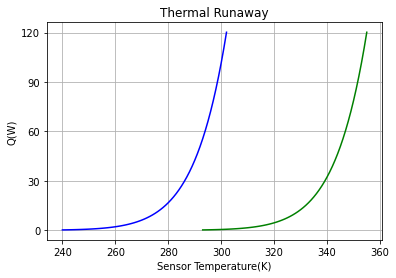

In [57]:

#plot Q(T) function

fig = plt.figure()
ax1 = fig.gca()
ax1.set_xticks(np.arange(240, 400,20 ))
ax1.set_yticks(np.arange(0, 3000, 30))
ax1.set_ylabel('Q(W)')
ax1.set_xlabel('Sensor Temperature(K)')
ax1.set_title('Thermal Runaway')

plt.plot(Ts,Q[1],'b',Ts_e,Q[1],'g')
plt.grid()
plt.show()


 ----------fit from curve_fit: y=exp(a+bx)


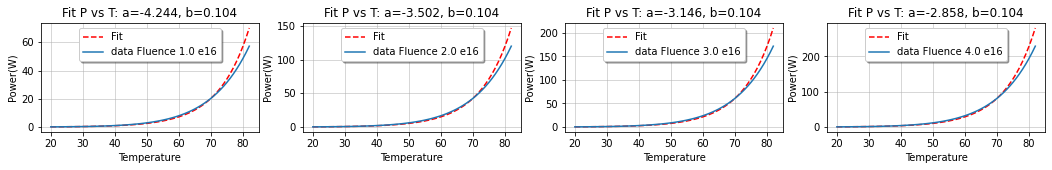


----------fit from linear fit ln(y)=ln(a)+ bx 


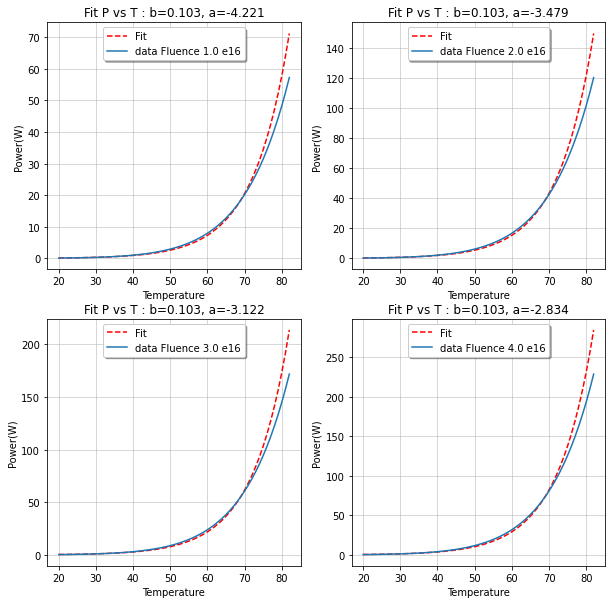


----------data 


In [58]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from lmfit import Model 
from iminuit import Minuit

def func(x, a, b): return np.exp(a + b * x)

x1 = Q_T.Ts_ec 
y1 = Q_T.Q1 
y2 = Q_T.Q2 
y3 = Q_T.Q3 
y4 = Q_T.Q4

#print('----------fit from lmfit: y=exp(a+bx)----------')
#gmodel = Model(func)
#result1 = gmodel.fit(y1, x=x1, a=0.1, b=0.1)
#result2 = gmodel.fit(y2, x=x1, a=0.1, b=0.1)
#result3 = gmodel.fit(y3, x=x1, a=0.1, b=0.1)
#result4 = gmodel.fit(y4, x=x1, a=0.1, b=0.1)
#print(result1.fit_report())
#plt.plot(x1, y1, 'bo', label='data' )
#plt.plot(x1, result.init_fit, 'k--', label='initial fit')
#plt.plot(x1, result.best_fit, 'r-', label='best fit')
#plt.legend(loc='best')
#plt.show()

print('\n ----------fit from curve_fit: y=exp(a+bx)')
fig, (ax01, ax02, ax03, ax04) = plt.subplots(1, 4, figsize=(18,2)) 
fnts='medium'

p0=0.1,0.1 
x=[Q_T.Ts,Q_T.Ts_e,Q_T.Ts_ec] 
y=[y1,y2,y3,y4] 
popt=[] 
pcov=[] 
ax=[ax01,ax02,ax03,ax04]

for i in range(0,4): 
    sigma=np.ones(len(y[i]))*y[i]
    popt_t, pcov_t = curve_fit(func, x1, y[i],p0,sigma=sigma,absolute_sigma=True) 
    popt.append(popt_t) 
    pcov.append(pcov_t) 
    
    ax[i].plot(x1,func(x1,*popt[i]),'r--',label='Fit') 
    ax[i].plot(x1,y[i],label='data Fluence %1.1f e16'%(i+1)) 
    ax[i].grid(linestyle='-', linewidth='0.5') 
    ax[i].set(ylabel='Power(W)',xlabel='Temperature', title='Fit P vs T: a=%5.3f, b=%5.3f'%tuple(popt[i])) 
    ax[i].legend(loc='upper center', shadow=True, fontsize=fnts) 

plt.show()
#------------------

print('\n----------fit from linear fit ln(y)=ln(a)+ bx ')

#Generated linear fit

#x1 = Q_T.Ts_ec 
y1data = np.log(Q_T.Q1) 
y2data = np.log(Q_T.Q2) 
y3data = np.log(Q_T.Q3) 
y4data = np.log(Q_T.Q4)

ydata=[y1data,y2data,y3data,y4data]

lfres=[]

for i in range(0,4): 
    lfres_t = stats.linregress(x1,ydata[i]) 
    lfres.append(lfres_t)
    #print(lfres[i][0:2])
    
lfd1=[]
lfd2=[]
lfd3=[]
lfd4=[]

for x in x1:
    lfd1.append(np.exp(lfres[0][1] + lfres[0][0]*x))        # power for linear fit
    lfd2.append(np.exp(lfres[1][1] + lfres[1][0]*x))        # power for linear fit
    lfd3.append(np.exp(lfres[2][1] + lfres[2][0]*x))        # power for linear fit
    lfd4.append(np.exp(lfres[3][1] + lfres[3][0]*x))        # power for linear fit

fig01, axs = plt.subplots(2, 2, figsize=(10,10))
axes=axs.flatten()
lfdata=[lfd1,lfd2,lfd3,lfd4]

for i in range(0,4):
    axes[i].plot(x1,lfdata[i],'r--',label='Fit')
    axes[i].plot(x1,y[i],label='data Fluence %1.1f e16'%(i+1))
    axes[i].grid(linestyle='-', linewidth='0.5')
    axes[i].set(ylabel='Power(W)',xlabel='Temperature', title='Fit P vs T : b=%5.3f, a=%5.3f'%lfres[i][0:2])
    axes[i].legend(loc='upper center', shadow=True, fontsize=fnts)

plt.show()


Q_T['Q_1lf']=lfdata[0]
Q_T['Q_2lf']=lfdata[1]
Q_T['Q_3lf']=lfdata[2]
Q_T['Q_4lf']=lfdata[3]
#Q_T['Q_lmf']=fdatalmf
#Q_T['Q_cvf']=fdatacvf
#Q_T['Q_diffcvf']=Q_T.Q_cvf-Q_T.Q2 Q_T['Q_difflf']=Q_T.Q_1lf-Q_T.Q1
#Q_T['diff']=100*(Q_T.Q2-Q_T.Q_f)/(Q_T.Q2+Q_T.Q_f)
print('\n----------data ')
#print(Q_T)
Q_T.to_csv(r'Q_T.csv', index = False)





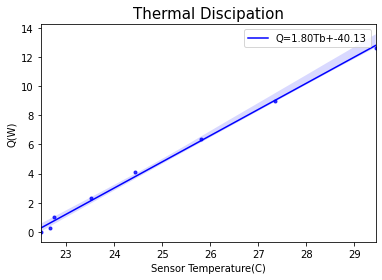

Thermal Conductance: 1.80 +/- 0.04 W/C 



,I,V,Tb,Tt,Q
0,0.00,0.00,22.478,22.439,0.0000
1,0.20,1.27,22.666,22.608,0.2540
2,0.40,2.54,22.758,22.698,1.0160
3,0.60,3.82,23.519,23.423,2.2920
4,0.80,5.10,24.442,24.488,4.0800
5,1.00,6.38,25.815,25.629,6.3800
6,1.19,7.57,27.347,27.099,9.0083
7,1.41,8.97,29.445,29.118,12.6477


In [59]:
#TIM + Ceramic Heater Thermal conductivity/impedance from experiments 

dataset1 = pd.read_csv("QT_V1.csv",sep=",", index_col=None) # read info from csv file: I,V,Tt=Ttop,Tb=Tbottom
dataset2 = pd.read_csv("QT_V2.csv",sep=",", index_col=None) # read info from csv file


df1 = pd.DataFrame() # create the data frame 
df2 = pd.DataFrame()
QT1 = dataset1
QT2 = dataset2

QT1["Q"]=QT1.I*QT1.V
QT2["Q"]=QT2.I*QT2.V

## Generated linear fit
slope_QT1, intercept_QT1, r_value_QT1, p_value_QT1, std_err_QT1 = stats.linregress(QT1.Tb,QT1.Q)

# use line_kws to set line label for legend
ax3 = sns.regplot(x="Tb", y="Q", data=QT1, color='b',marker=".", 
  line_kws={"linewidth": 1.5,'label':"Q={0:.2f}Tb+{1:.2f}".format(slope_QT1,intercept_QT1)}
                 )

ax3.set_ylabel('Q(W)')
ax3.set_xlabel('Sensor Temperature(C)')
pylab.title('Thermal Discipation',fontsize=15)
## plot legend
ax3.legend()

plt.show()
 #slope and std_err are the Mock module resistance and its error
print("Thermal Conductance: %.2f +/- %.2f W/C \n" %(slope_QT1,std_err_QT1) )
#print("----------------------------------------------------------\n") 

QT1

In [62]:
# calculation of the thermal load line 

qt1=[]
qt2=[]
qt3=[]
ts=[]
ts_e=[]
for t in range (240, 303):
    ts.append(t)
    ts_e.append(t-273)

for t in ts:
    qt1.append(slope_QT1*(t - T0)) # at T0 K there is no heat load 
    qt2.append(0.14*slope_QT1*(t - T0)) # same as qt1 half of thermal conductance 
    qt3.append(0.3*slope_QT1*(t - T0))
    
#plt.plot(ts,qt1,'r')

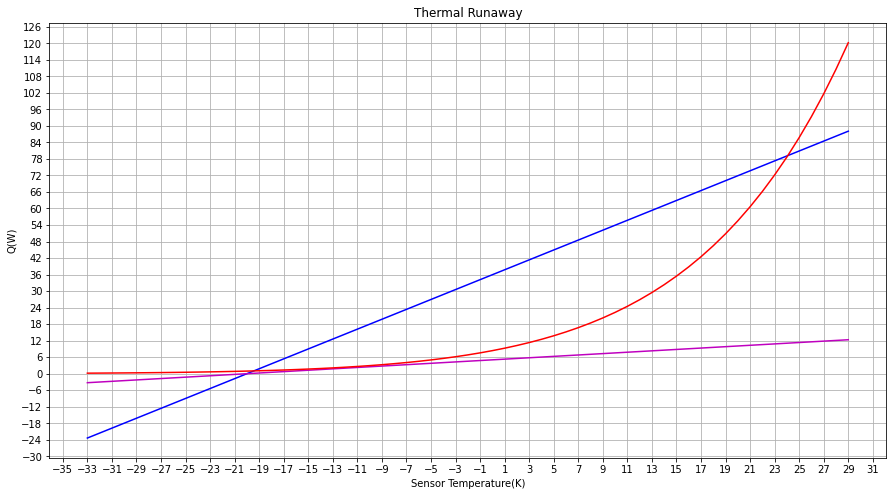

In [63]:
#plot Q(T) function and Thermal discipation

#fig2 = plt.figure()
fig2 = plt.figure(figsize=(15,8))
ax4 = fig2.gca()
ax4.set_xticks(np.arange(-35, 40, 2))
ax4.set_yticks(np.arange(-30, 130, 6))
ax4.set_ylabel('Q(W)')
ax4.set_xlabel('Sensor Temperature(K)')
ax4.set_title('Thermal Runaway')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
#plt.plot(ts_e,qt1,'b', ts_e,qt2,'m',ts_e,Q1,'g--', ts_e,Q2,'r', ts_e,Q3,'y--') #several fluences [1,2,3]x10^16
plt.plot(ts_e,qt1,'b', ts_e,qt2,'m',ts_e,Q2,'r') #several fluences [1,2,3]x10^16
plt.grid()
plt.show()

In [64]:
# The thermal balance is given by the intersection of Q(Ts) with the straight line (blue),
# which may be termed a load line. 

# when the load line is a tangent to the curve(magenta straight line), corresponds to the limit of stable operation
# which we will denote by "qrefcrit". For higher values of Qref the curve has no intersection with the load line
# and in this case the system will undergo thermal runaway: the sensor temperature will increase, 
# increasing further the sensor leakage power, and the sensor temperature must run away. 

In [65]:
#### range of stable operation 

qref=[]
Tsref=[]
Rt=1/slope_QT1

for T in Ts:
    if T>(T0-1):
        qref.append(((T-T0)/Rt)*((Tr/T)**2)*np.exp(Ta*(1/T - 1/Tr))/(h*l))
        Tsref.append(T-273)

df_qref=pd.DataFrame()
df_qref['qref']=qref
df_qref['Tsref']=Tsref
#df_qref

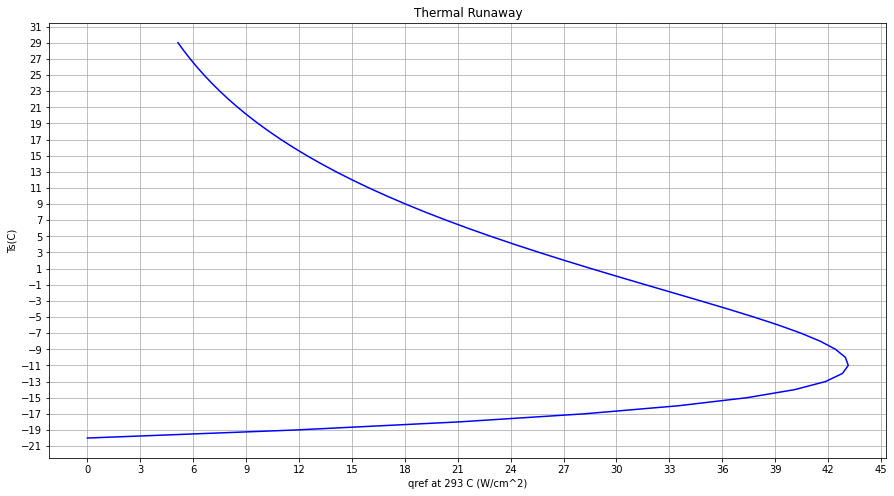

In [66]:
#plot Qref(T) function

fig3 = plt.figure(figsize=(15,8))
ax3 = fig3.gca()
ax3.set_xticks(np.arange(0, 50, 3 ))
ax3.set_yticks(np.arange(-33, 40, 2))
ax3.set_ylabel('Ts(C)')
ax3.set_xlabel('qref at 293 C (W/cm^2)')
ax3.set_title('Thermal Runaway')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(qref,Tsref,'b')
plt.grid()
plt.show()

In [67]:
Tscrit = T0 + T0**2/Ta
print("The critical temperature for thermal runaway Tscrit ~= %.2f"%Tscrit,'K ','(%.2f'%(Tscrit - 273),'C)')

The critical temperature for thermal runaway Tscrit ~= 262.14 K  (-10.86 C)


In [68]:
# the power Qcrit, dissipated by the sensor at the limit of stability, i.e. at Tscrit is given by:

Qcrit = (T0**2)/(Rt*Ta)

print('The power discipated by the sensor at Tscrit is Qcrit=%.2f'%Qcrit, 'W')


The power discipated by the sensor at Tscrit is Qcrit=16.44 W


In [69]:
# The corresponding critical leakage power at the reference temperature is 

qrefcrit =((Ta*(Tr**2))/((Ta + T0)**2)* np.exp(Ta*(1/Tscrit - 1/Tr)))/(Rt*h*l)
print('Critical leakage power at reference temperature is: %.2f' %qrefcrit,'W/cm^2')


Critical leakage power at reference temperature is: 43.15 W/cm^2


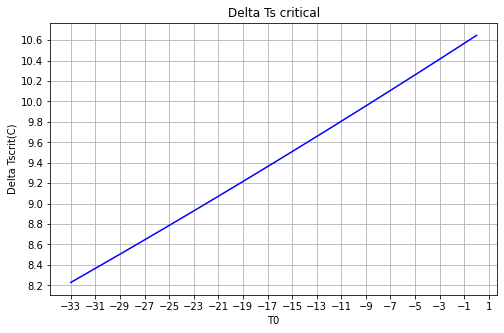

In [70]:
#plot T0 over the range of negative temperatures

# Over the range of T0 from 􏰂-30 to 0C, Delta Tscrit varies from 8.5 to 10.7 C. In this representation the critical
# parameters are dependent on the coolant sink temperature, and on the thermal resistance and hybrid heat to the
# extent that these determine T0, the temperature of the sensor when there is negligible contribution from leakage
# current.

T0r=[] # T0 range
dTscrit=[]
for T in range(240,274):
    T0r.append(T-273)
    dTscrit.append(T**2/Ta)
    
fig4 = plt.figure(figsize=(8,5))
ax4 = fig4.gca()
ax4.set_xticks(np.arange(-35, 2, 2 ))
ax4.set_yticks(np.arange(8, 12, 0.2))
ax4.set_ylabel('Delta Tscrit(C)')
ax4.set_xlabel('T0')
ax4.set_title('Delta Ts critical')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(T0r,dTscrit,'b')
plt.grid()
plt.show()


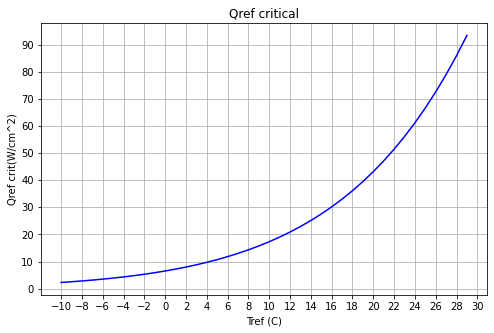

In [71]:
#Qrefcrit as a function of Tr
# This equation/function allows us to estimate,for a given leakage power,the headroom against thermal runaway.

Qrefcrit=[]
Tref=[]

for T in range(263,303):
    Qrefcrit.append(((Ta*(T**2))/((Ta + T0)**2)* np.exp(Ta*(1/Tscrit - 1/T)))/(Rt*h*l))
    Tref.append(T - 273)
    
#plot Qrefcrit over a range of reference temperatures

fig5 = plt.figure(figsize=(8,5))
ax5 = fig5.gca()
ax5.set_xticks(np.arange(-10, 32, 2 ))
ax5.set_yticks(np.arange(0, 120, 10))
ax5.set_ylabel('Qref crit(W/cm^2)')
ax5.set_xlabel('Tref (C)')
ax5.set_title('Qref critical')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(Tref,Qrefcrit,'b')
plt.grid()
plt.show()


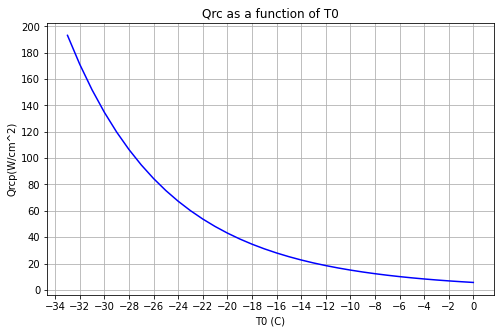

In [72]:

# Dependence of the critical leakage power on a change in T0 (Qrefcrit(T0,T0p)=Qrcp). To first order in T0/TA

Qrcp=[]

for T in range(240,274):
    Qrcp.append(qrefcrit*np.exp(Ta*(1/T - 1/T0)))


#plot Qrcp over a range of T0 temperatures

fig6 = plt.figure(figsize=(8,5))
ax6 = fig6.gca()
ax6.set_xticks(np.arange(-40, 32, 2 ))
ax6.set_yticks(np.arange(0, 220, 20))
ax6.set_ylabel('Qrcp(W/cm^2)')
ax6.set_xlabel('T0 (C)')
ax6.set_title('Qrc as a function of T0')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(T0r,Qrcp,'b')
plt.grid()
plt.show()

In [73]:
# It follows that for temperatures in the range of interest, the reduction in coolant temperature necessary to
# double the critical leakage power (Qrcp) is about 6.5C. (T0: -20C (~43 W/cm^2) -> -26.5C (~86 W/cm^2))


In [74]:
# To find the critical parameters in terms of a given leakage power we start with the coolant sink temperature
# to achieve a sensor temperature Ts

#if Ts~250K ^ Ta+2Ts~Ta +500=Tap : Ta_prime 

T0c = Tscrit*(1 - Tscrit/(Ta + 500)) # T0 critical

print('The critical coolant temperature based on current T0 is T0crit=%.2f'%T0c, '(%.2f'%(T0c-273),'C)')


# which then can be used to compute the critical coolant temperature, above which thermal runaway will occur:

# currently |RcQH| = |-33 - (-20)| = 13 (C or K)

RcQH = 13

Tccrit= T0c - RcQH 

print('The critical coolant temperature based on current T0 is Tccrit=%.2f'%Tccrit, '(%.2f'%(Tccrit-273),'C)')


# These values match our current values because all the calculations are based on T0, so in this sense T0
# is the critial value defined by design...... NOT VERY CLEAR TO ME

The critical coolant temperature based on current T0 is T0crit=252.98 (-20.02 C)
The critical coolant temperature based on current T0 is Tccrit=239.98 (-33.02 C)


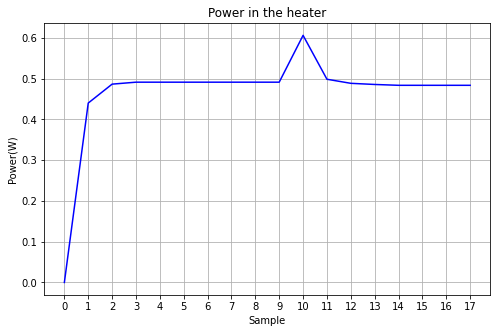

In [79]:
# data sets from experiments using carbon fiber-foam + PPE4 + water
# this dataset was taken using the Q(T) fit function considering temperatures up to 63 C. 
# An extended range in T requires a recalculation of the fit; this will be done next. 


ppe4= pd.read_csv("P_T_data_PPE4.csv",sep=",", index_col=None) # read info from csv file

P=ppe4.Power # Voltages from power supply (digital multmeter)
T=ppe4.Temp # T from thermocouple (digital multimeter)
S=ppe4.Sample # samples are taken each 3 minutes which is the T estabilization time   

fig7 = plt.figure(figsize=(8,5))
ax7 = fig7.gca()
ax7.set_xticks(np.arange(0, 20, 1 ))
ax7.set_yticks(np.arange(0,0.8, 0.1))
ax7.set_ylabel('Power(W)')
ax7.set_xlabel('Sample')
ax7.set_title('Power in the heater')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(S,P,'b')
plt.grid()
plt.show()


# the spike in  sample 10 corresponds to forcing the temprrature to rise up by touching the thermocouple,
# so the injected power is increased




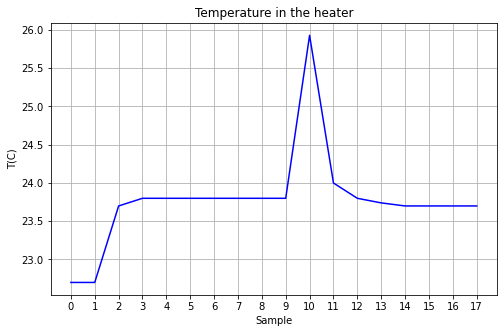

In [80]:
fig8 = plt.figure(figsize=(8,5))
ax8 = fig8.gca()
ax8.set_xticks(np.arange(0, 20, 1 ))
ax8.set_yticks(np.arange(20,30, 0.5))
ax8.set_ylabel('T(C)')
ax8.set_xlabel('Sample')
ax8.set_title('Temperature in the heater')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(S,T,'b')
plt.grid()
plt.show()

# The spike at sample 10 is the increase in T by touxhing the thermocouple



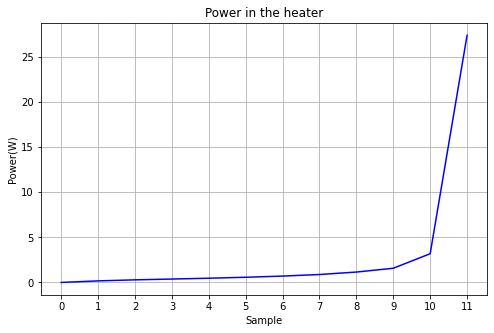

In [81]:
# data sets from experiments using heater in air

dtset = pd.read_csv("P_T_data_nonTIM_1.csv",sep=",", index_col=None) # read info from csv file

heater = pd.DataFrame() # create the data frame 
heater = dtset

P=heater.Power # Voltages from power supply (digital multmeter)
T=heater.Temp # T from thermocouple (digital multimeter)
S=heater.Sample

fig9 = plt.figure(figsize=(8,5))
ax9 = fig9.gca()
ax9.set_xticks(np.arange(0, 15, 1 ))
ax9.set_yticks(np.arange(0,30, 5))
ax9.set_ylabel('Power(W)')
ax9.set_xlabel('Sample')
ax9.set_title('Power in the heater')

plt.plot(S,P,'b')
plt.grid()
plt.show()

# the last value of. power is limited by the power supply since the commanded value (at T=108.93 C -> P~956 W)
# exceed its capabilities.

#print(heater)


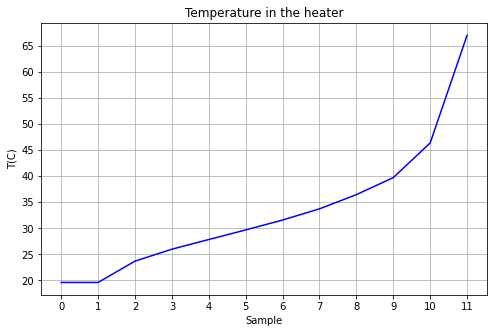

In [82]:
fig10 = plt.figure(figsize=(8,5))
ax10 = fig10.gca()
ax10.set_xticks(np.arange(0, 15, 1 ))
ax10.set_yticks(np.arange(20,1200, 5))
ax10.set_ylabel('T(C)')
ax10.set_xlabel('Sample')
ax10.set_title('Temperature in the heater')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(S,T,'b')
plt.grid()
plt.show()



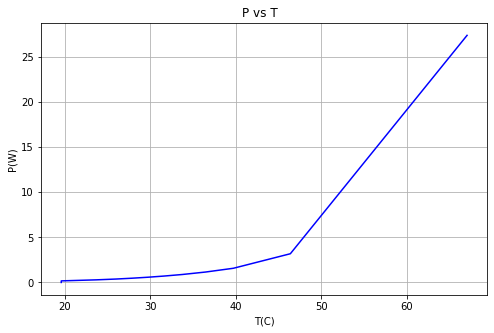

In [83]:
fig11 = plt.figure(figsize=(8,5))
ax11 = fig11.gca()
ax11.set_xticks(np.arange(0, 100, 10 ))
ax11.set_yticks(np.arange(0,50, 5))
ax11.set_ylabel('P(W)')
ax11.set_xlabel('T(C)')
ax11.set_title('P vs T  ')

#plt.plot(Ts,Q1,'r',Ts,Q2,'b',Ts,Q3,'g')
plt.plot(T,P,'b')
plt.grid()
plt.show()



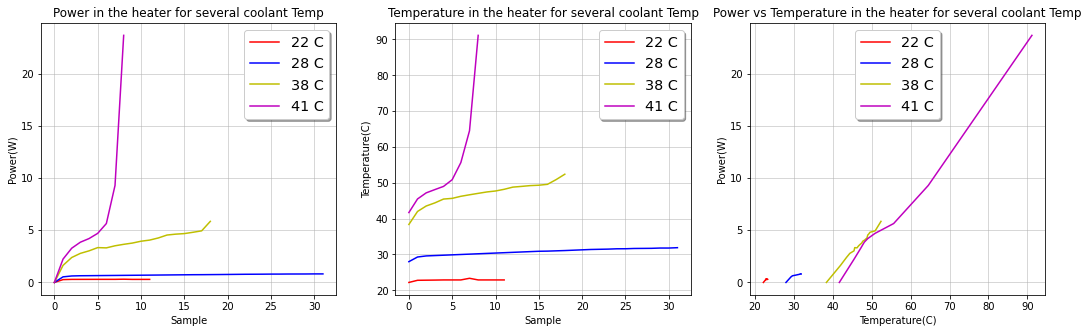

In [84]:
# Next round of experiments:  change the coolant temperature and force the thermal runaway. 
# Samples are taken after 3 minutes of estabilization time so it is a way toquantify time. 

dtsetpaths = open("dataset_coolant_T.txt", 'r')

# Create subplots 
f, ax = plt.subplots(1, 3, figsize=(18,5))

for line in dtsetpaths:
    path, color, Tcl= line.split()
    heater = pd.read_csv(path,sep=",", index_col=None)
    
    P=heater.Power # Voltages from power supply (digital multmeter)
    T=heater.Temp # T from thermocouple (digital multimeter)
    S=heater.Sample
    
    ax[0].plot(S,P,'%s'%color,label='%s C'%Tcl)
    ax[0].grid(linestyle='-', linewidth='0.5')
    ax[0].set(ylabel='Power(W)',xlabel='Sample', 
             title='Power in the heater for several coolant Temp')
    ax[0].legend(loc='upper right', shadow=True, fontsize='x-large')
    
    ax[1].plot(S,T,'%s'%color,label='%s C'%Tcl)
    ax[1].grid(linestyle='-', linewidth='0.5')
    ax[1].set(ylabel='Temperature(C)', xlabel='Sample',
             title='Temperature in the heater for several coolant Temp')
    ax[1].legend(loc='upper right', shadow=True, fontsize='x-large')
    
    ax[2].plot(T,P,'%s'%color,label='%s C'%Tcl)
    ax[2].grid(linestyle='-', linewidth='0.5',)
    ax[2].set(xlabel='Temperature(C)', ylabel='Power(W)',
             title='Power vs Temperature in the heater for several coolant Temp')
    ax[2].legend(loc='upper center', shadow=True, fontsize='x-large')
    
    
plt.show()


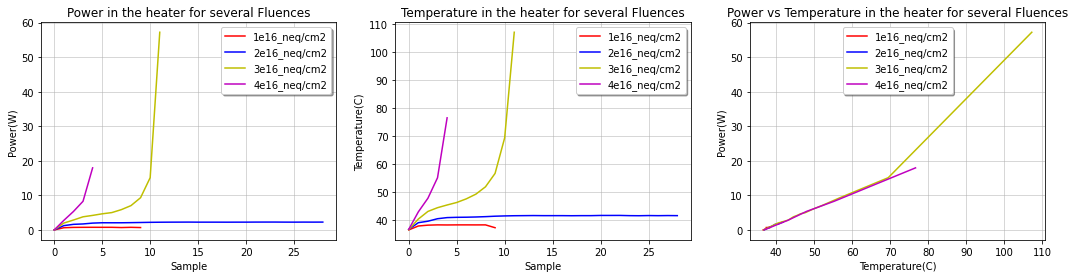

In [85]:
# Keep the coolant temperature fixed and force the thermal runaway by increasing the fluence. 
# Samples are taken after 3 minutes of estabilization time so it is a way to quantify time. 

dtsetpaths = open("dataset_fluence.txt", 'r')

fnts='medium'

# Create subplots 
f, ax = plt.subplots(1, 3, figsize=(18,4))

for line in dtsetpaths:
    path, color, Fl= line.split()
    heater = pd.read_csv(path,sep=",", index_col=None)
    
    P=heater.Power # Voltages from power supply (digital multmeter)
    T=heater.Temp # T from thermocouple (digital multimeter)
    S=heater.Sample
    
    ax[0].plot(S,P,'%s'%color,label='%s'%Fl)
    ax[0].grid(linestyle='-', linewidth='0.5')
    ax[0].set(ylabel='Power(W)',xlabel='Sample', 
             title='Power in the heater for several Fluences')
    ax[0].legend(loc='upper right', shadow=True, fontsize='medium')
    
    ax[1].plot(S,T,'%s'%color,label='%s'%Fl)
    ax[1].grid(linestyle='-', linewidth='0.5')
    ax[1].set(ylabel='Temperature(C)', xlabel='Sample',
             title='Temperature in the heater for several Fluences')
    ax[1].legend(loc='upper right', shadow=True, fontsize='medium')
    
    ax[2].plot(T,P,'%s'%color,label='%s'%Fl)
    ax[2].grid(linestyle='-', linewidth='0.5',)
    ax[2].set(xlabel='Temperature(C)', ylabel='Power(W)',
             title='Power vs Temperature in the heater for several Fluences')
    ax[2].legend(loc='upper center', shadow=True, fontsize='medium')
    
    
plt.show()

